In [1]:
import pandas as pd

In [20]:
df=pd.read_csv("C:\\Users\\pbhug\\Downloads\\archive\\data.csv", encoding = 'latin1')

In [22]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [30]:
# convert date column to datetime format
df['Date']= pd.to_datetime(df['InvoiceDate'])
# keep only the most recent date of purchase
df['rank'] = df.sort_values(['CustomerID','Date']).groupby(['CustomerID'])['Date'].rank(method='min')
df_rec = df[df['rank']==1]

In [36]:
df_rec.loc['recency'] = (df_rec['Date'] - pd.to_datetime(min(df_rec['Date']))).dt.days

C:\Users\pbhug\AppData\Local\Temp\ipykernel_25048\2287902059.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_rec.loc['recency'] = (df_rec['Date'] - pd.to_datetime(min(df_rec['Date']))).dt.days
C:\Users\pbhug\AppData\Local\Temp\ipykernel_25048\2287902059.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rec.loc['recency'] = (df_rec['Date'] - pd.to_datetime(min(df_rec['Date']))).dt.days


In [38]:
freq = df_rec.groupby('CustomerID')['Date'].count()
df_freq = pd.DataFrame(freq).reset_index()
df_freq.columns = ['CustomerID','frequency']

In [40]:
rec_freq = df_freq.merge(df_rec,on='CustomerID')

In [42]:
rec_freq['total'] = rec_freq['Quantity']*df['UnitPrice']
m = rec_freq.groupby('CustomerID')['total'].sum()
m = pd.DataFrame(m).reset_index()
m.columns = ['CustomerID','monetary_value']

In [44]:
rfm = m.merge(rec_freq,on='CustomerID')

In [46]:
finaldf = rfm[['CustomerID','recency','frequency','monetary_value']]

recency: 


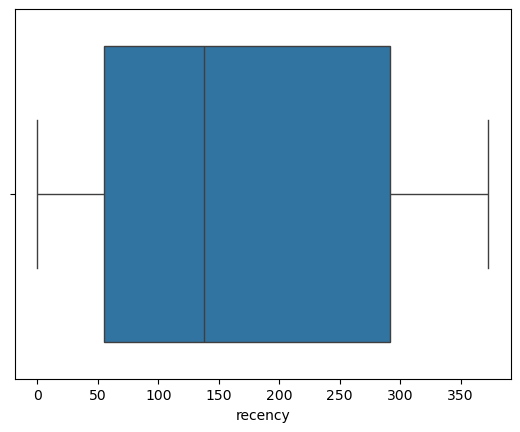

frequency: 


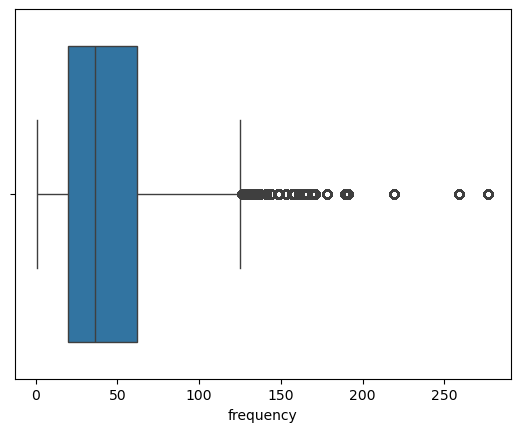

monetary_value: 


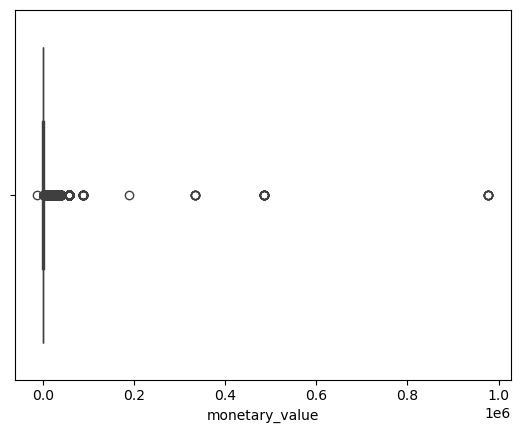

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt
list1 = ['recency','frequency','monetary_value']
for i in list1:
    print(str(i)+': ')
    ax = sns.boxplot(x=finaldf[str(i)])
    plt.show()

In [50]:
from scipy import stats
import numpy as np
# remove the customer id column
new_df = finaldf[['recency','frequency','monetary_value']]
# remove outliers
z_scores = stats.zscore(new_df)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
new_df = new_df[filtered_entries]

In [52]:
from sklearn.preprocessing import StandardScaler
new_df = new_df.drop_duplicates()
col_names = ['recency', 'frequency', 'monetary_value']
features = new_df[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)
scaled_features = pd.DataFrame(features, columns = col_names)

Text(0, 0.5, 'Inertia')

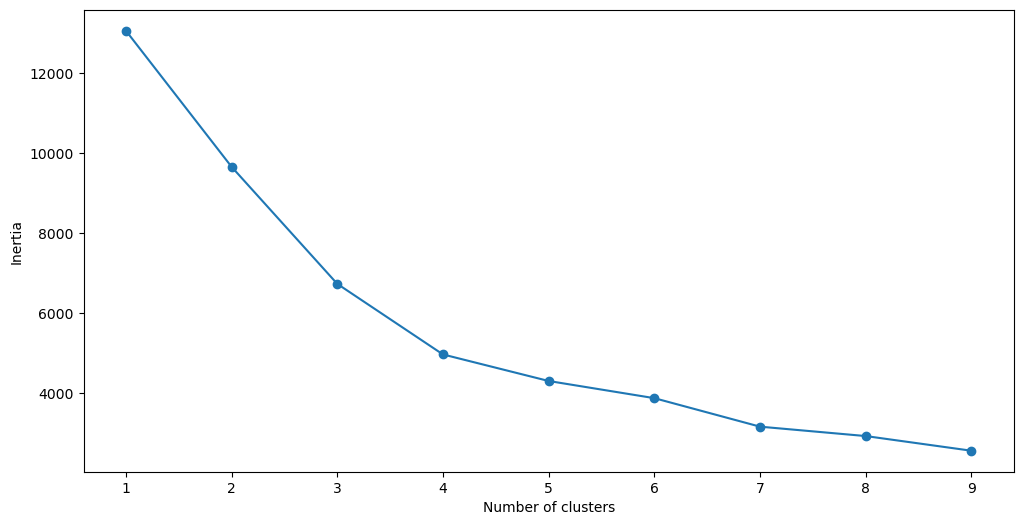

In [54]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
SSE = []
for cluster in range(1,10):
    kmeans = KMeans(n_clusters = cluster, init='k-means++')
    kmeans.fit(scaled_features)
    SSE.append(kmeans.inertia_)
# converting the results into a dataframe and plotting them
frame = pd.DataFrame({'Cluster':range(1,10), 'SSE':SSE})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

In [56]:
# First, build a model with 4 clusters
kmeans = KMeans( n_clusters = 3, init='k-means++')
kmeans.fit(scaled_features)

KMeans(n_clusters=3)

In [58]:
print(silhouette_score(scaled_features, kmeans.labels_, metric='euclidean'))

0.41039001502056965


In [60]:
pred = kmeans.predict(scaled_features)
frame = pd.DataFrame(new_df)
frame['cluster'] = pred

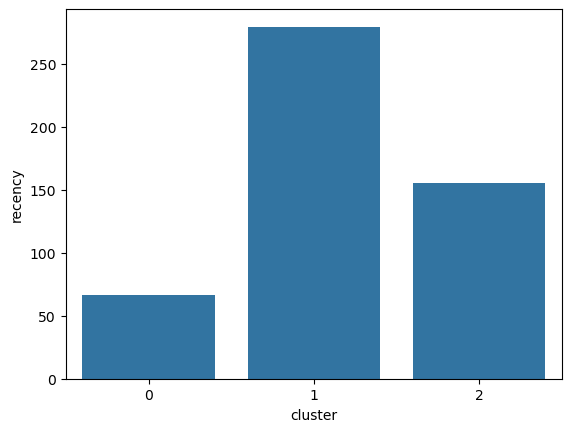

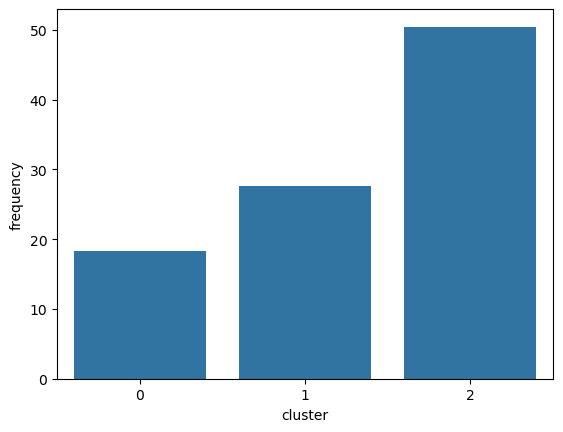

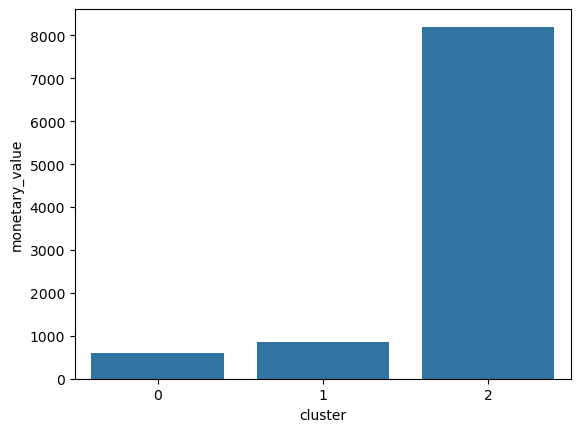

In [62]:
avg_df = frame.groupby(['cluster'], as_index=False).mean()
for i in list1:
    sns.barplot(x='cluster',y=str(i),data=avg_df)
    plt.show()